<a href="https://colab.research.google.com/github/jtwang1027/cancer_omics/blob/master/2B_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What features are criticial in determining phosphorylation?

---

Combining the transcriptomic, proteomic, phosphoproteomic, and copy number variant (CNV)

---



For this example, we will predict response to 'EGF' treatment based on initial conditions.



In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
import pandas as pd
import numpy as np
# from sklearn.metrics import mean_squared_error
# from math import sqrt
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans

import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

#xgboost
import xgboost
from xgboost import plot_importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics  import mean_squared_error
from math import sqrt

from sklearn.model_selection import train_test_split


In [0]:
pho=pd.read_csv('/content/drive/My Drive/median_phospho_data.csv')
rna=pd.read_csv('/content/drive/My Drive/rnaseqexononly_marcotte.csv')
pro=pd.read_csv('/content/drive/My Drive/proteomics_consolidated.csv')

In [0]:
predicted='p.STAT5'

In [0]:
# pho=pho[(pho.treatment=='full')| ((pho.treatment=='EGF') & (pho.time==60))]

y=pho[(pho.treatment=='EGF') & (pho.time==60)]
pho=pho[(pho.treatment=='full')]

In [12]:
y.head()

,cell_line,treatment,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
9,184A1,EGF,60.0,1.387644,2.380511,1.687352,3.019043,4.945261,1.971002,1.038883,2.299306,2.566744,3.451464,2.511451,0.477254,2.902384,1.931954,1.558872,4.752701,4.584944,2.083049,1.346200,1.805584,2.337472,2.119401,3.600856,2.321230,1.955401,1.415363,2.832417,2.403166,2.149662,5.107865,5.092896,1.989772,2.374451,1.800993,2.326742,2.433128,2.277509
48,184B5,EGF,60.0,0.701472,2.624060,1.559331,2.123604,5.836948,1.711272,2.078841,2.951335,2.200617,3.402234,2.836053,0.458253,2.673386,2.030302,1.839076,4.194177,4.704451,1.678014,1.343445,1.838409,2.918577,2.412224,3.842308,2.828036,2.428187,1.677360,2.643007,2.039500,2.278217,4.408503,5.250961,2.076611,2.056812,2.253833,2.594247,2.246455,2.739950
80,AU565,EGF,60.0,0.612624,1.606909,1.691062,1.896838,5.637191,3.057995,2.028169,NaN,2.172047,2.832928,2.697991,1.442841,NaN,1.952234,3.870384,3.435501,NaN,2.317428,1.622814,2.645934,3.372703,2.285538,4.734593,3.525845,2.908163,3.635976,5.214433,1.167030,NaN,3.876109,NaN,3.081120,1.643218,2.078699,3.132313,1.393637,3.419103
119,BT20,EGF,60.0,0.934534,2.246159,2.093256,2.448518,5.764426,2.557062,2.544115,4.701265,2.573458,3.420240,2.552222,1.551837,3.996405,2.678773,4.349992,3.255163,5.761866,2.124337,1.852183,2.845421,3.221769,2.034531,4.688123,3.177132,3.097863,2.448747,4.618962,1.381803,3.773417,3.423361,7.387691,2.528369,2.073428,2.700776,3.858893,1.927362,3.060014
158,BT474,EGF,60.0,0.939968,2.304067,1.608099,2.820131,5.742485,1.938516,2.424600,3.797367,2.550643,2.693943,2.615033,0.939538,3.052084,1.951432,3.949399,2.797792,4.736008,2.006449,1.464213,2.791771,2.470646,1.534034,3.367656,3.105729,1.915132,1.911112,2.763102,2.092404,1.853996,3.275360,6.654130,2.136761,1.720291,2.457390,3.401249,1.086139,2.717389


In [0]:
# rna.columns
rna.drop(['X', 'Unnamed: 0'],axis=1, inplace=True)

In [14]:
rna.head()

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL3,AADAT,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB11,...,PRG4,PSMA1,PSMA2,RBL1,RNASE11,RPP14,SDHD,SEPT1,SHPK,SLC25A10,SLC5A3,SNURF,SOGA3,SOX7,SRSF8,TAP2,TEC,TIMM10B,TLR9,TM4SF19,TM9SF1,TMBIM4,TMEM236,TMEM239,TMEM249,TUBB3,UGT2A1,UQCR11,ZFP41,ZMYM6,ZNF177,ZNF223,ZNF286A,ZNF33B,ZNF668,ZNF709,ZNF747,ZNF763,ZNF8,cell_line
0,-3.113,-2.914,5.767,2.394,4.522,3.376,-3.322,-3.322,1.062,5.507,2.602,4.955,5.779,-3.322,4.218,-0.078,5.011,0.941,4.076,2.924,5.637,0.373,4.920,-3.322,3.831,-1.440,-0.967,4.750,0.032,1.889,-2.376,0.511,3.796,-2.819,0.822,-3.322,-2.037,-3.322,3.492,-3.031,...,-0.578,7.182,6.709,1.932,-3.322,3.981,6.630,-2.400,1.775,0.561,3.281,5.371,-3.322,-0.604,4.236,3.121,-0.150,4.024,-3.322,-2.747,5.407,6.181,-3.322,-3.322,-3.322,2.599,-3.078,6.490,1.524,3.589,-1.207,0.553,3.622,2.744,1.727,-0.929,1.649,-2.487,0.376,184A1
1,2.298,-3.322,4.692,1.099,4.547,3.635,-3.322,-3.322,1.461,4.232,3.217,3.784,5.704,-3.322,4.154,-0.010,6.662,2.790,4.787,2.841,3.370,1.667,4.622,-1.332,1.452,-0.728,-0.197,5.781,-3.322,2.818,-1.792,-3.322,3.434,-0.491,0.562,-3.322,-2.067,-3.322,3.667,-3.322,...,-3.322,6.681,6.369,1.472,-3.322,3.690,5.057,-1.711,1.750,2.066,0.575,5.404,-3.322,3.097,3.717,4.738,-0.666,3.982,-3.087,0.447,4.810,5.796,-3.322,-3.322,-2.866,2.781,-3.322,6.749,1.111,3.450,-1.983,0.172,4.215,3.622,-0.347,-2.281,0.554,-3.322,2.173,184B5
2,-0.131,5.612,-2.902,0.193,4.643,4.838,-0.926,-3.322,1.350,4.661,1.310,6.112,5.910,-3.322,3.806,1.219,4.798,1.806,4.878,1.951,2.975,0.475,4.932,1.691,3.763,-0.520,-1.930,-3.322,-3.322,3.902,3.128,-1.423,1.454,-2.983,0.934,-3.322,-3.322,-3.322,4.256,-3.322,...,-3.322,7.126,6.474,2.518,-3.322,3.964,4.671,-1.080,2.158,4.165,1.200,5.282,-3.322,-3.322,1.838,2.723,0.450,4.016,-3.322,-3.322,5.743,5.516,-3.322,-3.322,-3.322,1.257,-3.322,6.769,2.016,2.746,-0.602,1.001,2.590,2.448,-0.505,-0.645,1.322,0.684,2.380,MPE600
3,0.423,-0.488,3.008,0.021,5.010,4.867,-1.982,-3.322,0.796,4.280,2.625,3.699,6.629,-3.322,5.004,2.574,4.835,2.249,3.647,2.683,4.590,-2.624,4.133,-3.322,-0.391,-1.927,-3.322,3.166,2.687,3.767,2.778,-0.383,2.387,-3.322,0.603,-3.322,-3.322,-3.322,3.269,-3.322,...,-3.322,7.252,7.308,3.403,-3.322,3.598,6.555,-3.322,3.677,5.147,2.231,1.667,-3.322,-2.801,3.769,4.569,0.111,4.141,-3.322,-3.322,5.994,5.976,-3.322,-3.322,-3.081,1.034,-3.322,5.970,-0.425,2.502,-3.322,0.095,3.073,2.245,2.341,-3.322,-0.101,-3.322,0.728,AU565
4,0.904,-3.322,-0.715,-1.611,4.365,4.156,-3.322,-3.322,-3.322,6.153,0.828,4.539,5.762,-3.322,4.430,-0.580,6.624,2.503,3.954,1.590,4.026,-0.633,5.812,-3.202,3.524,-1.601,-3.322,1.401,-3.322,3.588,-0.564,-0.427,-0.526,-3.322,2.150,-3.322,-3.322,-3.322,2.013,-3.322,...,-3.322,7.727,7.601,2.627,-3.322,3.390,6.260,-2.257,2.968,4.093,-3.322,-2.224,-3.322,-3.322,2.901,4.307,1.773,4.112,-3.322,2.193,4.683,5.302,-3.322,-3.322,-3.019,2.985,-3.322,7.257,0.977,1.018,0.913,1.496,3.496,2.199,0.332,-0.733,2.143,-0.296,1.167,BT20


In [0]:
pro.rename(columns={ 'Unnamed: 0':'cell_line'}, inplace=True)

In [16]:
pro.head()

,cell_line,A0A024RBG1,A0A087WUL8;P0DPF2;P0DPF3;Q3BBV2;Q6P3W6;Q8N660,A0A087X1C5;P10635,A0A096LP01,A0A0A6YYK6,A0A0B4J2D5;P0DPI2,A0A0B4J2F0,A0A0U1RR11;A0A0U1RRI6;P0DPI3,A0A0U1RRL7,A0A1B0GU71,A0AV02,A0AV96,A0AVT1,A0FGR8,A0JLT2,A0JNW5,A0MZ66,A0PJW6,A1A4S6,A1A5D9,A1KZ92,A1L020,A1L0T0,A1L170,A1L390,A1X283,A2RRP1,A2RUC4,A2VCL2,A3KMH1,A3KN83,A4D1E9,A4D1F6,A4D1P6,A4D1S0,A4D1S5,A5A3E0,A5D8V6,A5D8V7,...,Q9Y6G3,Q9Y6G5,Q9Y6G9,Q9Y6H1,Q9Y6H3,Q9Y6I3,Q9Y6I4,Q9Y6I8,Q9Y6I9,Q9Y6J9,Q9Y6K0,Q9Y6K1,Q9Y6K5,Q9Y6K8,Q9Y6K9,Q9Y6M1,Q9Y6M5,Q9Y6M7,Q9Y6M9,Q9Y6N1,Q9Y6N3,Q9Y6N5,Q9Y6N7,Q9Y6P5,Q9Y6Q5,Q9Y6R0,Q9Y6R4,Q9Y6T7,Q9Y6U3,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X2,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,MCF12A,0.0,0.0,0.0,-0.049267,0.000000,0.0,0.0,0.0,0.483507,0.086852,0.000000,-1.487639,-0.025162,0.485327,0.000000,0.000000,-1.135593,0.000000,-1.086574,0.0,-2.230968,0.000000,-1.332238,0.0,0.342369,0.560528,-0.574949,0.0,-2.509035,-0.412571,-0.821375,-0.355927,-0.665002,-0.488274,0.000000,-1.158968,0.000000,-0.556083,-0.613953,...,0.123961,0.051939,-0.229200,-0.239376,0.0,-0.462240,-0.648122,-3.721863,-0.094161,0.000000,0.173746,0.000000,-0.646602,0.0,0.134953,-0.196679,0.875858,-0.669411,0.165229,0.000000,-0.682805,0.839595,-0.121163,-1.306469,-0.967691,0.209331,-0.696071,0.308007,0.000000,-1.889580,-0.899191,0.301509,0.000000,-1.201301,-0.970549,0.0,-1.851081,-1.580570,-0.865814,0.003284
1,AU565,0.0,0.0,0.0,0.898216,-0.985849,0.0,0.0,0.0,0.150228,0.000000,0.000000,0.620711,-0.574947,-0.311711,0.000000,0.575404,1.357909,-1.778015,1.499091,0.0,0.895473,0.000000,0.964167,0.0,0.000000,-2.118251,-0.491312,0.0,0.000000,1.072634,-0.343047,0.303514,-0.451623,1.029040,-0.355470,1.133781,0.129086,0.172786,-0.090155,...,-0.748592,-0.545416,-0.071728,-0.584842,0.0,-0.206579,0.276719,2.363464,0.757839,-0.427766,-0.958593,-1.398265,0.069877,0.0,0.000000,0.000000,-0.508876,-0.570975,1.108220,-0.804275,0.081275,-1.285153,0.000000,0.000000,-0.490754,-0.097471,0.147986,0.000000,-4.071137,-0.855461,-0.280771,-0.605034,0.000000,0.090331,-0.084732,0.0,1.133150,0.340540,-1.071741,-0.205565
2,HCC1954,0.0,0.0,0.0,0.000000,-0.868302,0.0,0.0,0.0,-1.398618,-0.265187,0.000000,0.811323,0.405803,0.095134,-0.142155,0.000000,0.060257,-4.124408,0.000000,0.0,-0.445860,0.000000,-0.709515,0.0,0.307338,-0.123956,-0.899110,0.0,-2.239892,-0.953364,0.093493,-0.883459,0.899015,-0.556004,0.000000,-0.157332,0.000000,-0.363604,0.412309,...,-0.206874,-0.154476,-0.172175,0.044887,0.0,0.548246,-0.271768,0.000000,-0.506942,-0.415911,-0.269677,0.000000,0.941183,0.0,0.503473,-0.387935,-0.602299,-0.124295,-0.718702,-0.747458,-0.827176,0.530013,0.000000,0.000000,-0.440230,-0.093695,-0.708874,0.000000,0.000000,-2.491809,0.117394,-0.087318,0.000000,0.035589,0.481313,0.0,0.330495,-0.077987,-0.645387,-0.801501
3,OCUBM,0.0,0.0,0.0,-1.279137,-1.215071,0.0,0.0,0.0,-1.219686,0.459439,-0.357439,1.346222,0.193913,-0.292781,0.000000,0.727720,0.622312,1.106754,0.000000,0.0,0.047715,-1.550935,-0.070720,0.0,0.000000,-0.629159,-0.581517,0.0,0.000000,-0.286262,0.194860,0.853990,0.000000,1.644987,-0.340547,0.443267,-0.441699,-0.225225,-0.457929,...,0.148760,0.044830,-0.337781,-0.194756,0.0,-0.568503,0.818158,0.000000,0.093419,-0.674923,-1.404674,0.795436,-1.964782,0.0,-0.268656,0.000000,-1.396207,-1.321029,-0.004667,-0.738751,0.581342,-0.420048,0.000000,1.544920,-0.111734,0.000000,-0.019355,0.000000,0.000000,-0.993605,0.174562,-0.087074,0.000000,0.684258,0.000000,0.0,0.000000,0.066163,-1.676465,-0.983287
4,HCC1187,0.0,0.0,0.0,-0.353971,0.000000,0.0,0.0,0.0,-0.395183,-0.031582,0.000000,-2.680162,0.234843,-0.613488,0.000000,0.000000,-0.644168,0.000000,0.000000,0.0,-0.321961,1.437162,0.036495,0.0,0.000000,1.858171,1.837362,0.0,-2.487348,0.273965,-0.302122,0.222538,0.000000,0.818767,-2.000083,0.000000,-1.318872,0.577577,-1.047995,...,0.000000,-0.823257,0.265769,-0.639329,0.0,1.162066,-0.162388,0.000000,-0.814866,0.304525,0.000000,0.778202,1.154064,0.0,-0.394202,-4.641084,0.016719,-1.777071,-0.747793,0.000000,1.305643,-1.890484,0.00

combining phosphorylation, protein, and transcript data

In [0]:
total=pd.merge(pro,rna,on='cell_line', how='inner')
total=pd.merge(total,pho,on='cell_line', how='inner')
total.dropna(axis=1,inplace=True)


In [0]:
quant=total.dtypes=='float64' # quantitative columns

In [0]:
total.loc[:,quant]= MinMaxScaler().fit_transform(total.loc[:,quant])

In [21]:
total.head()

,cell_line,A0A024RBG1,A0A087WUL8;P0DPF2;P0DPF3;Q3BBV2;Q6P3W6;Q8N660,A0A087X1C5;P10635,A0A096LP01,A0A0A6YYK6,A0A0B4J2D5;P0DPI2,A0A0B4J2F0,A0A0U1RR11;A0A0U1RRI6;P0DPI3,A0A0U1RRL7,A0A1B0GU71,A0AV02,A0AV96,A0AVT1,A0FGR8,A0JLT2,A0JNW5,A0MZ66,A0PJW6,A1A4S6,A1A5D9,A1KZ92,A1L020,A1L0T0,A1L170,A1L390,A1X283,A2RRP1,A2RUC4,A2VCL2,A3KMH1,A3KN83,A4D1E9,A4D1F6,A4D1P6,A4D1S0,A4D1S5,A5A3E0,A5D8V6,A5D8V7,...,ZNF33B,ZNF668,ZNF709,ZNF747,ZNF763,ZNF8,treatment,time,b.CATENIN,cleavedCas,CyclinB,GAPDH_y,IdU,Ki.67,p.4EBP1,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.FAK,p.GSK3b,p.H3,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.RB,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
0,MCF12A,0.51184,0.0,0.0,0.493604,0.517119,0.0,0.385834,0.0,0.620615,0.705262,0.530471,0.454044,0.306544,0.772885,0.607966,0.560402,0.445736,0.728712,0.377102,0.694312,0.074351,0.576123,0.393513,0.582829,0.627716,0.649945,0.233317,0.600222,0.293688,0.563262,0.373923,0.334591,0.409164,0.440400,0.635976,0.201177,0.612046,0.468103,0.330779,...,0.766185,0.627300,0.147362,0.416940,0.009925,0.463728,full,0.0,0.472066,1.000000,0.844607,0.678716,0.694004,0.679713,0.529424,0.765981,0.716430,1.000000,0.099626,0.330998,0.598979,0.703690,1.000000,0.875411,0.392559,0.961485,0.968479,0.857529,0.663724,0.556219,0.291793,0.433857,0.654317,0.836546,0.661971,1.000000,0.667413,0.869008,0.318484,0.612356
1,AU565,0.51184,0.0,0.0,0.873873,0.327053,0.0,0.385834,0.0,0.548351,0.679417,0.530471,0.860227,0.124118,0.520230,0.607966,0.846314,0.919011,0.414567,0.888499,0.694312,0.712438,0.576123,0.708384,0.582829,0.512943,0.213141,0.246281,0.600222,0.615481,0.887622,0.542790,0.583965,0.482880,0.779300,0.581554,0.894905,0.639189,0.681472,0.510210,...,0.542001,0.986647,0.000000,0.253009,0.000000,0.193199,full,0.0,0.339235,0.256669,0.017558,0.226157,0.155006,0.441277,0.391242,0.231252,0.175911,0.293602,0.459502,0.105702,0.493828,0.504050,0.293964,0.457430,0.217387,0.626280,0.412075,0.444053,0.458645,0.296615,0.749571,0.759064,0.162771,0.593502,0.759116,0.327040,0.354398,0.312181,0.073114,0.560983
2,HCC1954,0.51184,0.0,0.0,0.513377,0.349716,0.0,0.385834,0.0,0.212513,0.600503,0.530471,0.896949,0.449543,0.649197,0.567137,0.560402,0.672713,0.000000,0.592006,0.694312,0.438680,0.576123,0.478898,0.582829,0.615972,0.538332,0.183071,0.600222,0.328207,0.445156,0.696904,0.135100,0.949489,0.425272,0.635976,0.504247,0.612046,0.524449,0.682333,...,0.301231,0.357270,0.445855,0.440140,0.564981,0.171537,full,0.0,0.000000,0.053944,0.298867,0.201567,0.444143,0.377788,0.000000,0.638292,0.545387,0.566259,0.369529,0.369618,0.593040,0.459103,0.449097,0.281989,0.120760,0.568782,0.298712,0.640960,0.289971,0.854175,0.185591,1.000000,0.035483,0.728336,0.484757,0.394060,0.704644,0.426674,0.478624,0.812334
3,OCUBM,0.51184,0.0,0.0,0.000000,0.282861,0.0,0.385834,0.0,0.251311,0.816136,0.263825,1.000000,0.379235,0.526230,0.607966,0.921998,0.779393,0.924256,0.592006,0.694312,0.539416,0.236507,0.566486,0.582829,0.512943,0.455953,0.232299,0.600222,0.615481,0.590847,0.732690,0.792132,0.638904,0.916875,0.583838,0.685973,0.519169,0.564958,0.384226,...,0.303638,0.543323,0.704482,0.589407,0.335206,0.627456,full,0.0,0.597771,0.375735,0.187908,0.697691,0.151039,0.454984,0.621389,0.360544,0.755227,0.531954,0.297358,0.330926,0.701717,0.402233,0.272434,0.580099,0.447132,0.583673,0.258142,0.488368,0.430730,0.560588,0.898323,0.445285,0.591426,0.154595,0.631803,0.565944,0.647662,0.511318,0.103702,0.640473
4,HCC1187,0.51184,0.0,0.0,0.371312,0.517119,0.0,0.385834,0.0,0.430089,0.670019,0.530471,0.224298,0.392816,0.424568,0.607966,0.560402,0.539010,0.728712,0.592006,0.694312,0.463967,0.890825,0.581187,0.582829,0.512943,0.861539,0.607235,0.600222,0.296470,0.713197,0.557238,0.553343,0.638904,0.732335,0.329762,0.551852,0.334723,0.799971,0.182094,...,0.253077,0.492878,0.650932,0.043117,0.223970,0.816121,full,0.0,0.472066,0.460628,0.414064,0.652944,0.138375,0.656624,0.533107,0.781365,0.633849,0.840806,0.291205,0.493786,0.618877,0.4450

In [0]:
common=list(set(y.cell_line) & set(total.cell_line))

In [0]:
y=y[y.cell_line.isin(common)]
total=total[total.cell_line.isin(common)]

In [0]:
total.sort_values(by='cell_line', inplace=True)
y.sort_values(by='cell_line',inplace=True)

In [0]:
y=y[predicted]

In [0]:
total.drop(predicted, axis=1, inplace=True)

In [0]:

X_train,X_test,y_train,y_test = train_test_split(total.loc[:,quant],y,test_size = 0.10, random_state=1234)

XGBoost model to generate predictions and understand feature importance

In [0]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
model.fit(X_train,y_train)

In [117]:

print("XGBoost RMSE: " + 
str(sqrt(mean_squared_error( model.predict(X_test), y_test))))

XGBoost RMSE: 0.2679157106985608


Text(0.5, 1.0, 'Xgboost Feature importance')

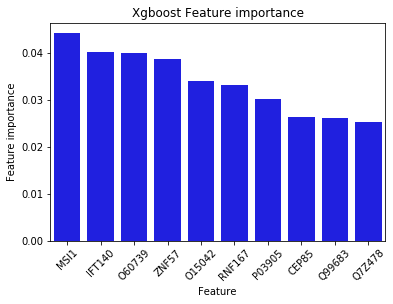

In [118]:
imp=pd.DataFrame(zip(X_train.columns,model.feature_importances_), columns=['features','impt'])
imp.sort_values(by='impt',inplace=True,ascending=False)
g=sns.barplot('features',y='impt',data=imp.iloc[:10,:], color ='b')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Feature importance')
plt.title('Xgboost Feature importance')

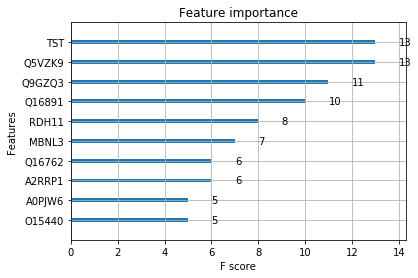

In [120]:
plot_importance(model, max_num_features=10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

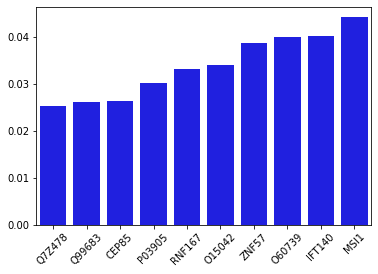

In [122]:
# order=np.argsort(model.feature_importances_)
# g=sns.barplot(x=X_train.columns[order[-10:]] ,y=model.feature_importances_[order[-10:]], color='b')
# plt.xticks(rotation=45)
# plt.xlabel('Feature')

# plt.ylabel('Relative Importance')
# plt.title('XGBoost: Feature importance')

Using Random forests to understand feature importance and generate predictions.

In [0]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

In [105]:
print("XGBoost RMSE: " + 
      str(sqrt(mean_squared_error( regr.predict(X_test), y_test))))

XGBoost RMSE: 0.10740948887717357


In [0]:
order2=np.argsort(regr.feature_importances_)
g=sns.barplot(x=X_train.columns[order2[-10:]] ,y=regr.feature_importances_[order2[-10:]], color='r')
plt.xticks(rotation=45)
plt.xlabel('Feature')

plt.ylabel('Relative Importance')
plt.title('Random forest: Feature importance')

Text(0.5, 1.0, 'Random forest: Feature importance')

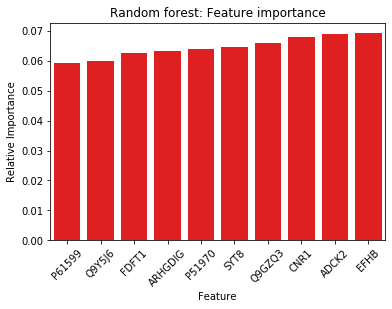

In [115]:
g=sns.barplot(x=X_train.columns[order2[-10:]] ,y=regr.feature_importances_[order2[-10:]], color='r')
plt.xticks(rotation=45)
plt.xlabel('Feature')

plt.ylabel('Relative Importance')
plt.title('Random forest: Feature importance')

There is significant disagreement in the top 10 features based on xgboost and RF models (given these parameters).

In [0]:
elastic= ElasticNet(random_state=0, normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
